In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r'C:\Users\swasa\Desktop\RSCCASN.csv')

In [3]:
df.head()

,DATE,RSCCASN
0,1992-01-01,6938
1,1992-02-01,7524
2,1992-03-01,8475
3,1992-04-01,9401
4,1992-05-01,9558


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 2 columns):
DATE       334 non-null object
RSCCASN    334 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.3+ KB


In [5]:
df.shape

(334, 2)

In [6]:
df.isnull().sum()

DATE       0
RSCCASN    0
dtype: int64

In [7]:
# changing the Data feature as index 
df = pd.read_csv(r'C:\Users\swasa\Desktop\RSCCASN.csv', parse_dates = True, index_col = 'DATE')

In [8]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [9]:
df.shape

(334, 1)

In [10]:
df.columns = ["Sales"]

In [12]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


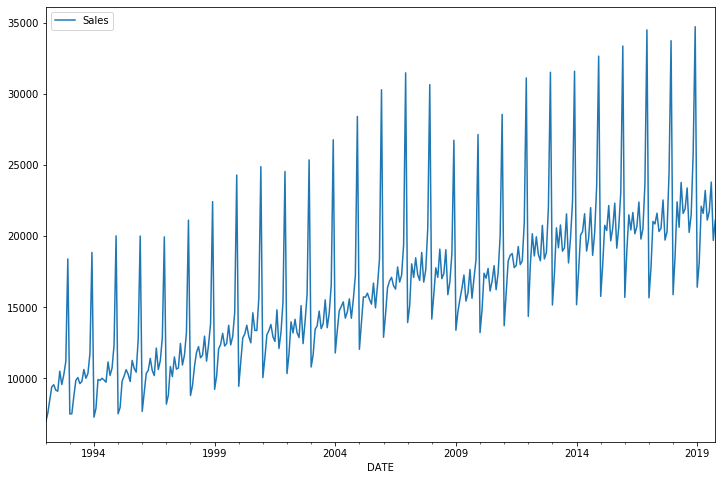

In [13]:
df.plot(figsize = (12,8))

In [14]:
len(df)

334

In [15]:
len(df) - 18

316

In [16]:
test_size = 18
test_ind = len(df) - test_size

In [17]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [18]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [19]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
scaler = MinMaxScaler()

In [22]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [23]:
scaled_train = scaler.transform(train)

In [24]:
scaled_test = scaler.transform(test)

In [25]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [26]:
# actul lenght of my batch sholud be less than the actual len of my test set to implement EarlyStopping
len(test)

18

In [27]:
length = 12 
generator = TimeseriesGenerator(scaled_train, scaled_train, length = length, batch_size = 1)

In [28]:
X,y = generator[0]

In [29]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [30]:
y

array([[0.02047633]])

In [31]:
from tensorflow.keras.models import Sequential

In [32]:
from tensorflow.keras.layers import Dense, LSTM

In [33]:
n_features = 1

In [34]:
model = Sequential()

model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [35]:
from tensorflow.keras.callbacks import EarlyStopping

In [36]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [37]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length = length, batch_size = 1)

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit_generator(generator, epochs = 20, validation_data = validation_generator, callbacks = [early_stop] )

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
304/304 [==============================] - 11s 37ms/step - loss: 0.0268 - val_loss: 0.0133
Epoch 2/20
304/304 [==============================] - 9s 29ms/step - loss: 0.0192 - val_loss: 0.0193
Epoch 3/20
304/304 [==============================] - 9s 28ms/step - loss: 0.0174 - val_loss: 0.0021
Epoch 4/20
304/304 [==============================] - 9s 28ms/step - loss: 0.0113 - val_loss: 6.4618e-04
Epoch 5/20
304/304 [==============================] - 9s 30ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 6/20
304/304 [==============================] - 9s 29ms/step - loss: 0.0028 - val_loss: 0.0030


In [40]:
losses = pd.DataFrame(model.history.history)

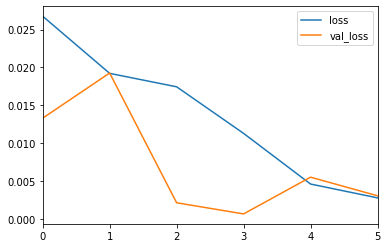

In [41]:
losses.plot()

In [42]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length, n_features))

for i in range (len (test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis = 1)

In [43]:
true_predictions = scaler.inverse_transform(test_predictions)

In [44]:
test['Predictions'] = true_predictions

C:\Users\swasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22483.069020
2018-06-01,21589,21502.955562
2018-07-01,21919,21750.148984
2018-08-01,23381,23413.742808
2018-09-01,20260,21128.076648
2018-10-01,21473,21815.349457
2018-11-01,25831,25430.058483
2018-12-01,34706,36110.613050
2019-01-01,16410,17677.472882


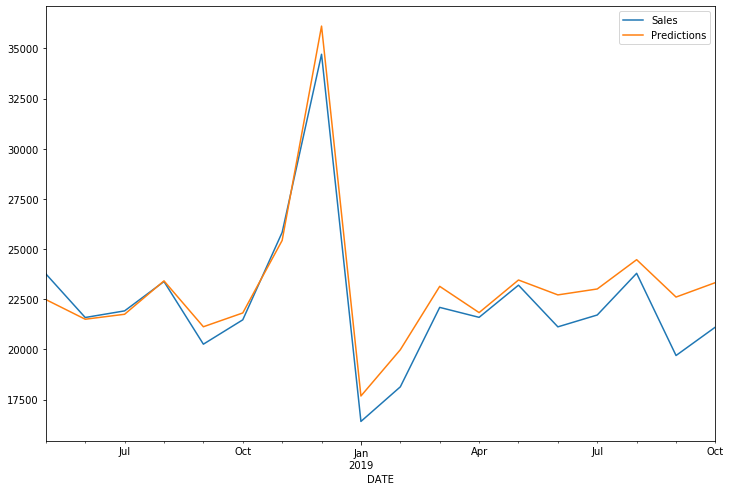

In [46]:
test.plot(figsize = (12,8))

In [47]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [48]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [50]:
model = Sequential()

model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs = 4)

Epoch 1/4
322/322 [==============================] - 12s 37ms/step - loss: 0.0273
Epoch 2/4
322/322 [==============================] - 9s 29ms/step - loss: 0.0187: 0s - loss:
Epoch 3/4
322/322 [==============================] - 9s 29ms/step - loss: 0.0118
Epoch 4/4
322/322 [==============================] - 9s 28ms/step - loss: 0.0063


In [51]:
forecast = []

periods = 20

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1,length, n_features))

for i in range (periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis = 1)

In [52]:
forecast = scaler.inverse_transform(forecast)

In [53]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [54]:
forecast

array([[ 30926.20354319],
       [ 50005.8461132 ],
       [ 18087.41465688],
       [ 20309.0952394 ],
       [ 24729.1164608 ],
       [ 24545.15505219],
       [ 26757.21990299],
       [ 24607.47753668],
       [ 25768.04726648],
       [ 28910.66605806],
       [ 24567.93926334],
       [ 29473.79791546],
       [ 66252.54176521],
       [158210.36007309],
       [ 11398.36928809],
       [ 20069.69602633],
       [ 29505.2768364 ],
       [ 33950.06632423],
       [ 41161.31348324],
       [ 49063.95424461]])

In [55]:
forecast_index = pd.date_range(start = '2019-11-01', periods = periods, freq = 'MS')

In [56]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01'],
              dtype='datetime64[ns]', freq='MS')

In [58]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [59]:
forecast_df

,Forecast
2019-11-01,30926.203543
2019-12-01,50005.846113
2020-01-01,18087.414657
2020-02-01,20309.095239
2020-03-01,24729.116461
2020-04-01,24545.155052
2020-05-01,26757.219903
2020-06-01,24607.477537
2020-07-01,25768.047266
2020-08-01,28910.666058


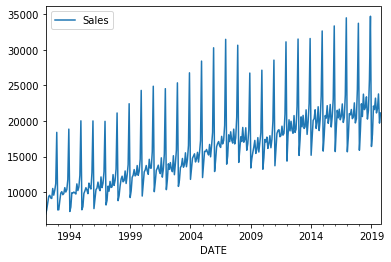

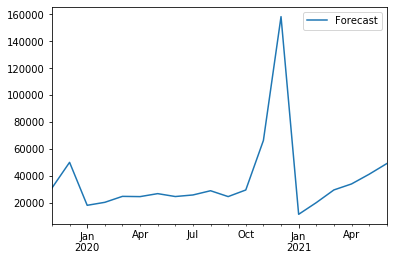

In [62]:
df.plot()
forecast_df.plot()

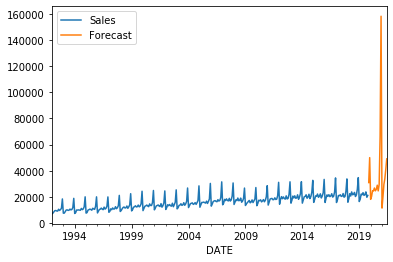

In [63]:
ax = df.plot()
forecast_df.plot(ax = ax)